# General 2-planet system

Derive the precession mode frequencies and amplitudes for a generic, closely-packed, 2-planet system. By generic, we mean that each planet has a generic set of initial conditions for (mass, semimajor axis, inclination).

In [79]:
# import packages
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
import time

import lzma, pickle
import scipy.fft as fft
import scipy.integrate as integ
import scipy.interpolate as interp
import scipy.optimize as optimize

import astropy.units as u
from astropy import constants as const

import rebound

# Method 1: Simulation

In [80]:
# initialize inclinations
rng = default_rng()
inc_scale = 1.8 * np.pi / 180 # inclination scale in radians

# b_inc_0_rad = rng.rayleigh(scale=inc_scale)
# c_inc_0_rad = rng.rayleigh(scale=inc_scale)
b_inc_0_rad = 0.039505988
c_inc_0_rad = 0.069253338
print(f'b_inc_0_rad = %.9f' % b_inc_0_rad)
print(f'c_inc_0_rad = %.9f' % c_inc_0_rad)

b_inc_0_rad = 0.039505988
c_inc_0_rad = 0.069253338


In [81]:
## Initialize simulation
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')

M_e = 3.00273e-6 # Earth mass in Msun

star_mass = 1.0
P_ratio = 1.51

# Each planet has 3 provided params: mass (m) in Earth masses, semimajor axis (a), 
# and inclination (inc). The four omitted orbital params (e, f, omega, Omega) 
# are left at their default values of 0.
b_params = {
    "m": 4.19 * M_e, 
    "a": 0.0719, 
    "inc": b_inc_0_rad,
    "Omega": 0
}

c_params = {
    "m": 4.16 * M_e, 
    "a": b_params['a'] * P_ratio**(2/3), # a \propto P^(2/3)
    "inc": c_inc_0_rad,
    "Omega": np.pi
}

sim.add(m=star_mass)
sim.add(m=b_params['m'], a=b_params['a'], inc=b_params['inc'], Omega=b_params['Omega'])
sim.add(m=c_params['m'], a=c_params['a'], inc=c_params['inc'], Omega=c_params['Omega'])

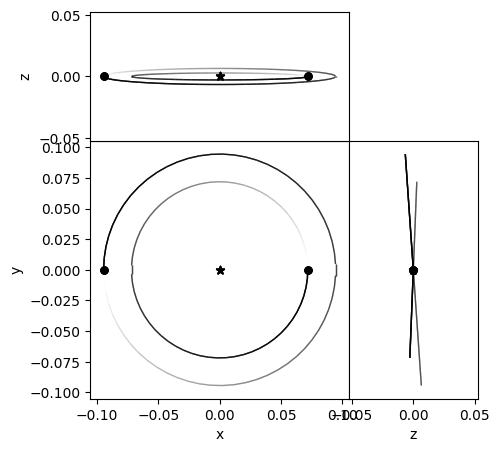

In [82]:
op_set = rebound.OrbitPlotSet(sim)

In [83]:
Lx, Ly, Lz = sim.angular_momentum()
Lx, Ly, Lz

(2.046058699737648e-22, 8.335372514136286e-07, 4.526580337265717e-05)

## Run sim

Per Appendix 1 in Su & Lai (2022), we track complex inclination $\mathcal{I}_j \equiv I_j \text{exp}(i \Omega_j)$.

In [84]:
tstep = 1
tmax = 2e3 # end time of integration (yr)
num_steps = int(tmax / tstep)

b_incs_rad = np.asarray([0.] * num_steps) # inclination (radians) of Planet B over the sim
c_incs_rad = np.asarray([0.] * num_steps) # inc (radians) of Planet C over the sim

b_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Planet B over the sim
c_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Planet C over the sim

b_as = np.asarray([0.] * num_steps) # semimajor axis of Planet B over the simulation
c_as = np.asarray([0.] * num_steps) # a of Planet C over the simulation

times = np.linspace(0, tmax, num_steps)

start = time.time()
for i, t in enumerate(times):
    # update inclination arrays
    inc_b = sim.particles[1].inc
    inc_c = sim.particles[2].inc
    b_incs_rad[i] = inc_b
    c_incs_rad[i] = inc_c
    
    # update complex inclination arrays
    Omega_i_b = sim.particles[1].Omega
    Omega_i_c = sim.particles[2].Omega
    b_complex_incs_rad[i] = inc_b * np.exp(1j * Omega_i_b)
    c_complex_incs_rad[i] = inc_c * np.exp(1j * Omega_i_c)
    
    # update semimajor axis arrays
    b_as[i] = sim.particles[1].a
    c_as[i] = sim.particles[2].a
    
    # move forward by one timestep
    sim.integrate(t)

print(f'Integration took {np.round(time.time() - start, 1)} seconds')

Integration took 16.5 seconds


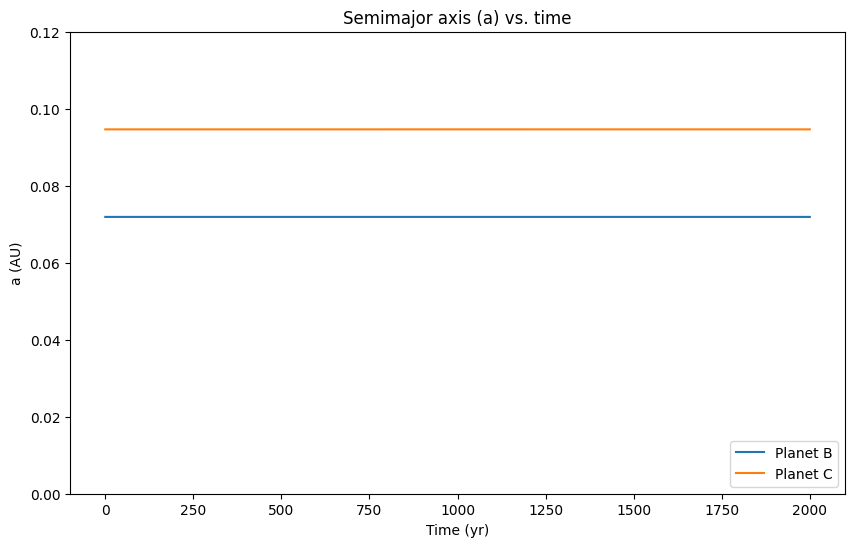

In [85]:
# check that semimajor axes aren't wandering
fig = plt.figure(figsize=(10,6))

plt.plot(times, b_as, label='Planet B')
plt.plot(times, c_as, label='Planet C')

plt.xlabel('Time (yr)')
plt.ylabel('a (AU)')
plt.ylim(0, .12)

plt.title('Semimajor axis (a) vs. time')
plt.legend(loc='lower right')
plt.show()

In [86]:
# convert inclinations from radians to degrees
b_incs_deg = b_incs_rad * (180 / np.pi)
c_incs_deg = c_incs_rad * (180 / np.pi)
b_complex_incs_deg = b_complex_incs_rad * (180 / np.pi)
c_complex_incs_deg = c_complex_incs_rad * (180 / np.pi)

# save data
file_path = f'bc_complex_incs_%.1E_yrs.pkl' % tmax
with lzma.open(file_path, 'wb') as f:
    pickle.dump((times, b_complex_incs_deg, c_complex_incs_deg), f)

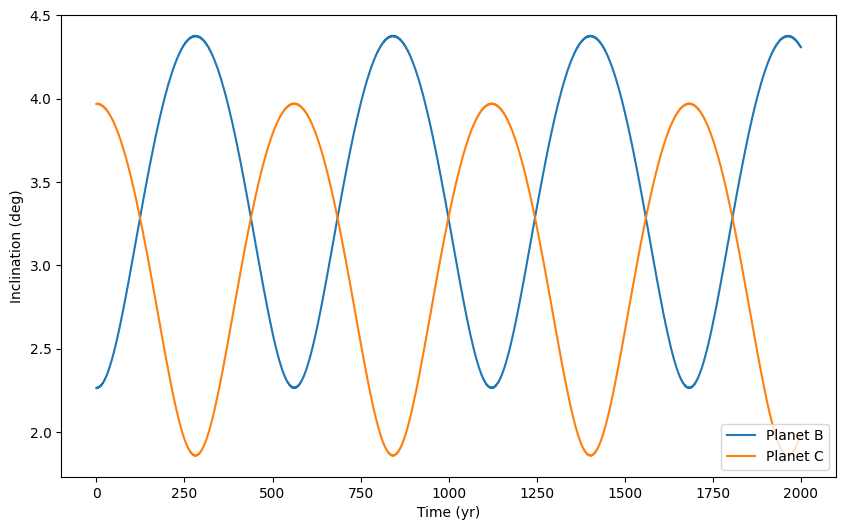

In [87]:
# load in data, if necessary
load_data = True
if load_data:    
    tmax = 2e3
    file_path = f'bc_complex_incs_%.1E_yrs.pkl' % tmax

    ## open old data files
    with lzma.open(file_path, 'rb') as f:
        times, b_complex_incs_deg, c_complex_incs_deg = pickle.load(f)

b_incs_deg = np.abs(b_complex_incs_deg)
c_incs_deg = np.abs(c_complex_incs_deg)

fig = plt.figure(figsize=(10,6))

plt.plot(times, b_incs_deg, label='Planet B')
plt.plot(times, c_incs_deg, label='Planet C')

plt.xlabel('Time (yr)')
plt.ylabel('Inclination (deg)')

plt.legend(loc='lower right')
plt.show()

## Apply FFT to sim data

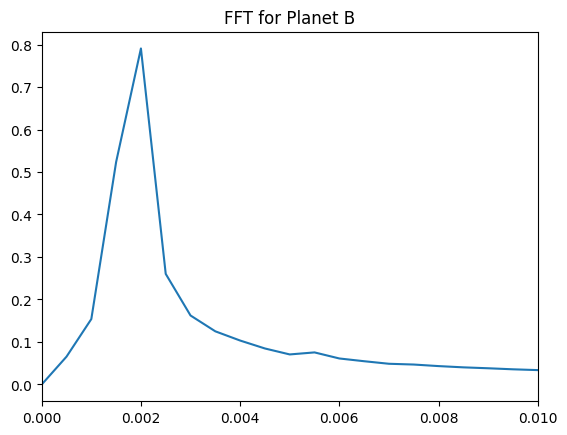

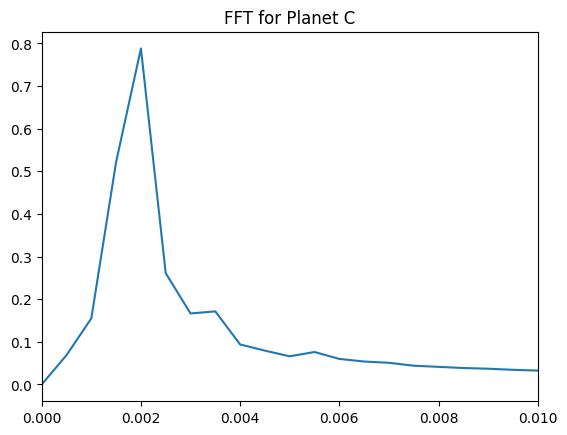

Planet B period: 500 years
Planet B amplitude: 0.791 deg
Planet C period: 500 years
Planet C amplitude: 0.788 deg


In [88]:
if load_data:
    num_steps = int(tmax)
    tstep = int(1)

N = int(num_steps)

def FFT_period_amp(incs, planet_name):
    '''
    Given a time series for a planet's inclination (incs), return the period
    and amplitude of the time series. NOTE: This implementation is for 2 planets.
    
    '''
    
    # only look at the positive side of the FFT
    yf = np.abs(fft.fft(incs - np.mean(incs))[:N//2])
    yf_scaled = 2 / num_steps * np.abs(yf)
    xf = fft.fftfreq(num_steps, tstep)[:N//2]
    
    # plot FFT result
    plt.plot(xf, yf_scaled)
    plt.xlim(0, 0.01)
    plt.title('FFT for ' + planet_name)
    plt.show()

    # return period (years) and amplitude (degrees)
    return 1 / xf[np.argmax(yf)], yf_scaled[np.argmax(yf)]

b_period, b_amp = FFT_period_amp(b_incs_deg, 'Planet B')
c_period, c_amp = FFT_period_amp(c_incs_deg, 'Planet C')

print(f'Planet B period: %0.f years' % b_period)
print(f'Planet B amplitude: %0.3f deg' % b_amp)
print(f'Planet C period: %0.f years' % c_period)
print(f'Planet C amplitude: %0.3f deg' % c_amp)

### Quadratic interpolation w/ FFT result

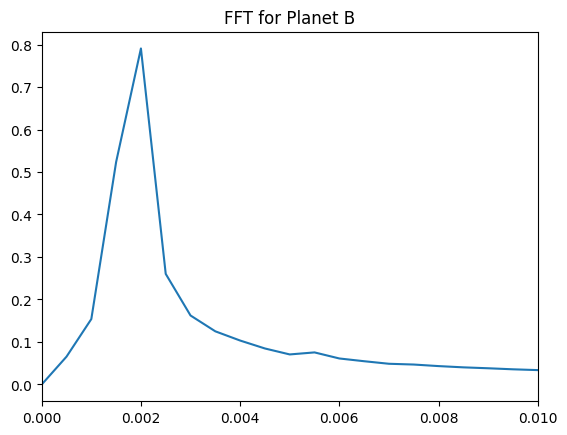

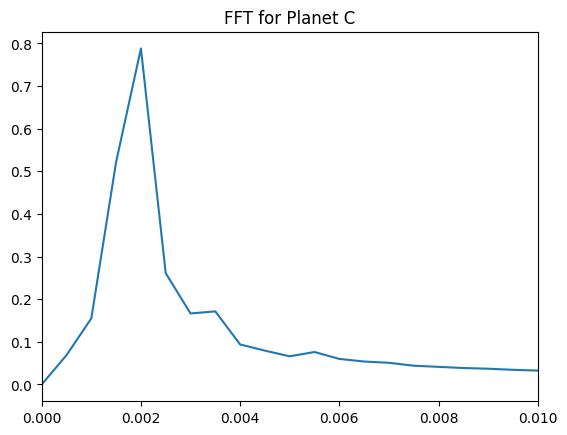

Planet B period (w/ interp): 522 years
Planet B amplitude (w/ interp): 0.802 deg
Planet C period (w/ interp): 521 years
Planet C amplitude (w/ interp): 0.799 deg


In [89]:
def quad_fn(coeffs, x):
    '''
    
    Given the coefficients of a quadratic polynomial f(x), return f(x).
    
    PARAMETERS
    ----------
    coeffs: 3-element list containing the quadratic's coefficients, 
    highest power first.
    x: the value at which to evaluate f(x).
    
    '''
    
    a, b, c = coeffs
    
    return a * x**2 + b * x + c

def FFT_period_amp_interp(incs, planet_name):
    '''
    Given a time series for a planet's inclination (incs), interpolate near
    the peak of the FFT transform and return the period and amplitude of the time series.
    NOTE: This implementation is for 2 planets.
    
    This is essentially the function FFT_period_amp implemented with
    the quadratic interpolation.
    
    '''
    
    # only look at the positive side of the FFT
    yf = np.abs(fft.fft(incs - np.mean(incs))[:N//2])
    yf_scaled = 2 / num_steps * np.abs(yf)
    xf = fft.fftfreq(num_steps, tstep)[:N//2]
    
    # plot FFT result
    plt.plot(xf, yf_scaled)
    plt.xlim(0, 0.01)
    plt.title('FFT for ' + planet_name)
    plt.show()
    
    x_vals = [xf[np.argmax(yf) - 1], xf[np.argmax(yf)], xf[np.argmax(yf) + 1]]
    y_vals = np.abs([yf[np.argmax(yf) - 1], yf[np.argmax(yf)], yf[np.argmax(yf) + 1]])
    y_vals_scaled = 2 / num_steps * np.abs(y_vals)

    # get coefficients of the interpolated quadratic function
    coeffs = np.polyfit(x_vals, y_vals_scaled, deg=2)
    a, b, c = coeffs
    
    # get mode freq and amplitude
    mode_f = - b / (2*a) # peak of the quadratic function
    mode_amp = quad_fn(coeffs, mode_f)

    # return period (years) and amplitude
    return 1 / mode_f, mode_amp

b_period_interp, b_amp_interp = FFT_period_amp_interp(b_incs_deg, 'Planet B')
c_period_interp, c_amp_interp = FFT_period_amp_interp(c_incs_deg, 'Planet C')

print(f'Planet B period (w/ interp): %0.f years' % b_period_interp)
print(f'Planet B amplitude (w/ interp): %0.3f deg' % b_amp_interp)
print(f'Planet C period (w/ interp): %0.f years' % c_period_interp)
print(f'Planet C amplitude (w/ interp): %0.3f deg' % c_amp_interp)

## Sanity check

Do a sanity check with `scipy.optimize`. See [this link](https://scipy-lectures.org/intro/scipy/auto_examples/plot_curve_fit.html).

[ 1.03941432  0.01120878 -1.57725954  3.40323788]


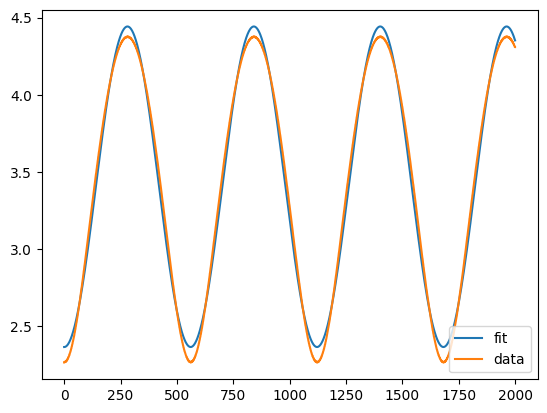

In [90]:
def test_func(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

guess = [2, .011, -1.57, 3.25]
params, params_covariance = optimize.curve_fit(test_func, times, b_incs_deg,
                                               p0=guess)
print(params)

a, b, c, d = params
plt.plot(times, test_func(times, a, b, c, d), label='fit')
plt.plot(times, b_incs_deg, label='data')
plt.legend()
plt.show()

# Analytic formula

I check that the mode frequency formula (Su & Lai 2022, Equation A2) matches our simulation's frequencies.

In [91]:
def laplace_coeff_integrand(x, alpha):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). Following Eq. A3 in Su & Lai 2022, we
    use j=1 and s=3/2. The result is used in the laplace_coeff function.
    
    PARAMETERS
    ----------
    x: argument of the function
    alpha: variable that isn't integrated over
    
    '''
    
    num = np.cos(x) # numerator
    denom = (1 - 2 * alpha * np.cos(x) + alpha**2) ** (3/2)
    
    return num / denom

def laplace_coeff(alpha):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.
    (This is the exact form of Eq. A3 in Su & Lai 2022.) The result is used 
    in mode_freq (and is denoted as "b").
    
    PARAMETERS
    ----------
    alpha: input to the formula.
    
    '''
    
    return 1 / np.pi * integ.quad(laplace_coeff_integrand, 0, 2*np.pi, args=(alpha))[0]
    
def mode_freq(a_j, a_k, m_k, M_star):
    
    '''
    
    Calculate the precession rate (w_jk) of the j-th planet 
    induced by the k-th planet.
    
    PARAMETERS
    ----------
    a_j, a_k: semimajor axes of planets j and k, respectively; assumes that
    parameters are provided with units (e.g., u.au or u.m)
    m_k, M_star: masses of planet k and the central star, respectively; assumes
    that parameters are provided with units (e.g., u.kg or const.M_sun)
    
    '''
    # np.min, max don't work with astropy quantities
    a_min, a_max = a_j, a_k
    if (a_k < a_j):
        a_min = a_k
        a_max = a_j
        
    n_j = np.sqrt(const.G * M_star / (a_j**3))
    alpha = a_min / a_max
    b = laplace_coeff(alpha)
    
    return m_k / (4 * M_star) * \
            (a_j * a_min) / (a_max**2) * \
            n_j * b

In [92]:
planet_inds = ['b', 'c']

# calculate omega_jk values in yr^-1 (but without the unit)
# format: omega_jk = mode_freq(j_params['a']*u.au, k_params['a']*u.au, \
    # k_params['m']*const.M_sun, star_mass*const.M_sun).to(u.yr**-1).value
for j in planet_inds:
    for k in planet_inds:
        if (j == k): continue
        exec('omega_' + j + k + ' = ' + \
             'mode_freq(' + j + "_params['a']*u.au, " + k + "_params['a']*u.au, " + \
             k + "_params['m']*const.M_sun, star_mass*const.M_sun).to(u.yr**-1).value")

## NOTE: This implementation is for 2 planets.
mat = np.array([
    [-omega_bc, omega_bc],
    [omega_cb, -omega_cb]
])
 
eigs, eigvs = np.linalg.eig(mat)
prec_freq = eigs[np.where(np.abs(eigs) > 1e-10)]
prec_eigv = eigvs[:, np.where(np.abs(eigs) > 1e-10)]
prec_eigv = np.squeeze(prec_eigv).T # reshape to (2,), ie each row is an eigv
zero_mode_ind = np.where(np.abs(eigs) < 1e-10)[0] # index of mode w/ frequency=0

# Note: for 2 planets, prec_freq = -(w_js + w_sj)
print(f'Period: %.2f years' % (2 * np.pi / (-prec_freq)))
print(f'Non-zero mode frequencies: {prec_freq}')
print(f'Corresponding mode eigenvectors: {prec_eigv}')

Period: 484.67 years
Non-zero mode frequencies: [-0.01296382]
Corresponding mode eigenvectors: [-0.75148311  0.65975233]


In [93]:
print(eigs)
print(eigvs)

[-0.01296382  0.        ]
[[-0.75148311 -0.70710678]
 [ 0.65975233 -0.70710678]]


In [94]:
# check that eigenvalues and eigenvectors match
print(f"Matrix \"divided\" by eigenvector: {np.matmul(mat, np.squeeze(prec_eigv)) / prec_eigv}")
print(f'Eigenvalues: {eigs}')

Matrix "divided" by eigenvector: [-0.01296382 -0.01296382]
Eigenvalues: [-0.01296382  0.        ]


## Mode amplitudes (attempt 2)

(to be revised/elaborated on later)  

Let B be the eigenvectors matrix: 
$$B = \begin{pmatrix}
\vec{I}^{(1)} & \vec{I}^{(2)}
\end{pmatrix}
=
\begin{pmatrix}
I_1^{(1)} & I_1^{(2)} \\
I_2^{(1)} & I_2^{(2)}
\end{pmatrix}$$

Then:
$$ B \vec{c} = \vec{i}_\text{init} $$

The mode amplitude is $\left| c_2 \vec{I}^{(2)} \right|$.

In [95]:
eigvs_mat = eigvs[:, [1, 0]]
print(f'eigvs_mat: {eigvs_mat}')

incs_init_deg = np.array([b_incs_deg[0], -c_incs_deg[0]])
print(f'incs_init_deg: {incs_init_deg}')

c = np.linalg.solve(eigvs_mat, incs_init_deg)
print(f'c: {c}')

# check solution correctness:
print(f'Solution correct? {np.allclose(np.dot(eigvs_mat, c), incs_init_deg)}')

eigvs_mat: [[-0.70710678 -0.75148311]
 [-0.70710678  0.65975233]]
incs_init_deg: [ 2.26352638 -3.96792398]
c: [ 1.49160214 -4.4155994 ]
Solution correct? True


In [96]:
np.abs(c[1] * eigvs_mat[:,1])

array([3.31824837, 2.913202  ])

## Mode amplitudes (attempt 1; doesn't work)

Calculate mode amplitudes given the initial complex inclination vector $\vec{\mathcal{I}}_0$ (which has $n$ entries) and the eigenvectors. 

Let $n$ be the number of planets. Reading from Eq. A1 in Su & Lai (2022), the eigenvalue problem can be written as:

$$ \frac{d\vec{\mathcal{I}}}{dt} = i\sum_{k=1}^{n-1} g_k \left(\vec{\mathcal{I}}_0 \cdot \frac{\vec{v}_k}{|\vec{v}_k|}\right)\vec{v}_k = i\sum_{k=1}^{n-1} g_k \left(\vec{\mathcal{I}}_0 \cdot \vec{v}_k\right)\vec{v}_k \equiv \sum_{k=1}^{n-1} g_k \vec{A}_k.$$

The second-to-last step comes from the fact that the eigenvectors are normalized, so $|\vec{v}_k| = 1$. The goal is to find the $n-1$ mode amplitudes, each of which is defined as $\vec{A}_k \equiv i\left(\vec{\mathcal{I}}_0 \cdot \vec{v}_k\right)\vec{v}_k$.

To get the complex inclination variation for a given planet $n$, we take the $n$th component of the above equation:

$$ \frac{d\mathcal{I}_n}{dt} = \sum_{k=1}^{n-1} g_k \left(\mathcal{I}_{0, n} v_{k, n}\right)v_{k,n} \equiv \sum_{k=1}^{n-1} g_k A_{k,n}.$$



The inclination variation is simply $I_n = |\mathcal{I}_n|$.

In [97]:
def get_mode_amps(complex_inc_0, eigvs, zero_mode_ind):
    '''
    Given the initial complex inclination vector inc_0 and the set of 
    eigenvectors (eigvs) for a system, compute the mode amplitudes 
    (which are the projections of inc_0 onto the eigenvectors). NOTE: In the below
    calculation, the eigenvector with eigenvalue 0 is set to the zero vector.
    (The index of this eigenvector is given by zero_mode_ind.)
    
    Let n be the number of planets. inc_0 has shape (n,), and eigvs has shape
    (n, n), where the columns (i.e. eigvs[:,i]) are the eigenvectors. The output 
    will have shape (n, n), and the ith column corresponds to mode amplitude i.
    (The column at A_vecs[:,zero_mod_ind] will be the zero vector.)
    
    
    '''
    
    n = len(complex_inc_0)
    complex_inc_0 = np.expand_dims(complex_inc_0, axis=1) # change shape to (n, 1)
    # eigvs[:,zero_mode_ind] = np.zeros((n, 1))
    
    scalars = np.matmul(np.conj(complex_inc_0.T), eigvs) # complex inner product 
    diag_mat = np.zeros((n,n), dtype=complex)
    np.fill_diagonal(diag_mat, scalars)
    A_vecs = 1j * np.matmul(eigvs, diag_mat)
    
    print(f'complex_inc_0.T: {complex_inc_0}')
    print(f'scalars: {scalars}')
    print(f'diag_mat: {diag_mat}')
    
    return A_vecs

In [98]:
temp_i = 20
inc_0_temp = np.asarray([b_complex_incs_deg[temp_i], c_complex_incs_deg[temp_i]])
mode_amps = get_mode_amps(inc_0_temp, eigvs, zero_mode_ind)
print('Mode amplitudes:')
print(mode_amps)
print('Magnitudes of mode amplitudes:')
print(np.abs(mode_amps))

complex_inc_0.T: [[ 2.19270802-0.70126925j]
 [-3.90548394+0.61594678j]]
scalars: [[-4.22443518-0.93336432j  1.21111547-0.0603321j ]]
diag_mat: [[-4.22443518-0.93336432j  0.        +0.j        ]
 [ 0.        +0.j          1.21111547-0.0603321j ]]
Mode amplitudes:
[[-0.70140752+3.17459168j -0.04266124-0.85638796j]
 [ 0.61578928-2.78708095j -0.04266124-0.85638796j]]
Magnitudes of mode amplitudes:
[[3.25115438 0.85744989]
 [2.85429793 0.85744989]]


# Yubo Testo

mean (x-component of total complex angular momentum): -1.057948540775158
ratio of oscillating component of inclinations of two planets, initial: -1.141409947539661
ratio of components of non-zero eigenvector: -1.1390382021118017
Mode amplitudes along either planet (should be equal): -4.419892983997338, -4.410708850812745


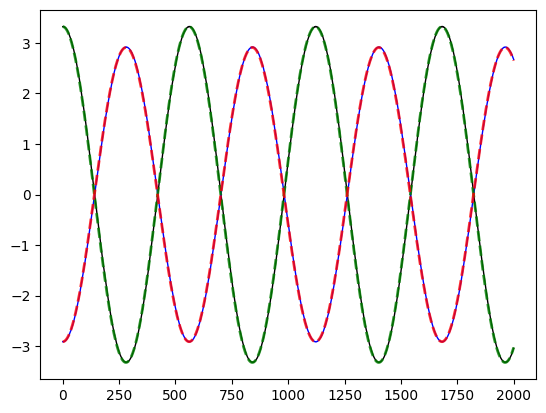

In [99]:
'''
This is the intuitive picture of what is going on. Let's focus on the real piece of the complex inclinations for now.

The two inclination timeseries will both oscillate about some mean value. The mean value is just the mean angular momentum
The oscillatory amplitudes correspond to the inclination oscillations that we want to analyze
Thus, we just need to extract the amplitudes of those oscillations, to get the mode amplitude
If we do this correctly AND have understood the dynamics correctly, then the oscillation amplitudes
  of each individual planet should be proportional to the components of the nonzero-frequency eigenvector
  (see my first set of prints below)
'''
eigs, eigvs = np.linalg.eig(mat)
# print(f'eigenvalues: {eigs}')
# print(f'eigenvectors: {eigvs}')
b0 = b_complex_incs_deg[0].real
c0 = c_complex_incs_deg[0].real
bc_mean = np.mean((b_complex_incs_deg.real + c_complex_incs_deg.real) / 2)
print(f'mean (x-component of total complex angular momentum): {bc_mean}')
print(f'ratio of oscillating component of inclinations of two planets, initial: {(b0 - bc_mean) / (c0 - bc_mean)}')
print(f'ratio of components of non-zero eigenvector: {eigvs[0,0]/ eigvs[1,0]}')

# NB: b is the period obtained from the curve_fit piece; it's your most
# accurate frequency it seems. Maybe the FFT just isn't accurate enough
# Assertion: (b0 - bc_mean) and (c0 - bc_mean) are the components of the inclination timeseries
# along the eigenvector with nonzero frequency. Is this correct?
# oscillating components of the inclination vectors (real part)
plt.plot(times, b_complex_incs_deg.real - bc_mean, 'k', lw=1)
plt.plot(times, c_complex_incs_deg.real - bc_mean, 'b', lw=1)
# prediction based on our manual extraction above
plt.plot(times, (b0 - bc_mean) * np.cos(b * times), 'g--', lw=2, alpha=0.8)
plt.plot(times, (c0 - bc_mean) * np.cos(b * times), 'r--', lw=2, alpha=0.8)

# As such, define the "mode amplitude" of this solution to be:
amp1 = (b0 - bc_mean) / eigvs[0, 0]
amp2 = (c0 - bc_mean) / eigvs[1, 0]
print(f'Mode amplitudes along either planet (should be equal): {amp1}, {amp2}')

My prediction for omega: -0.011202081962954252, compared to yours:0.011208782996319038
My resulting period: 560.8944237292978 years
Comparison with Jupiter Attempt 1: [-3.32053737  2.91521159]


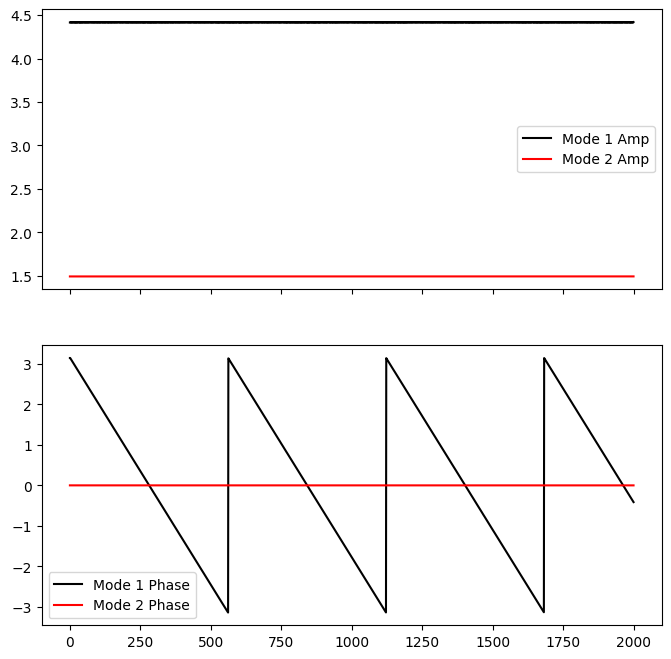

In [100]:
### Now that we have shown the intuitive understanding of the mode amplitude, can we calculate it cleanly?
# At each moment in time, the complex inclination vector of planet i should look like
# I_i(t) = sum_j v_{i,j} * A_j(t) [EQ 1]
# where v_{i,j} = eigvs[i, j] is the component of the j-th eigenvector along the i-th planet,
# and A_j is the component of planet i's inclination along mode j. In general, A_j(t) is a function of time
# but we should expect that
# A_j(t) = A_j * exp(sqrt(-1) * omega_j * t)
# where A_j is a complex constant.

# I don't think this approach is exactly either of your approaches above, which may be why you may have
# gotten wrong answers

ys_a_vals = np.zeros((len(times), 2), dtype=np.complex64)
for t in range(len(times)):
    ivec = [b_complex_incs_deg[t], c_complex_incs_deg[t]]
    # to get A_j, we just invert [EQ 1] above (which is secretly a matrix multiplication)
    # conveniently, this inverse should also take care of the complex conjugate that we were worried about
    a_j = np.matmul(np.linalg.inv(eigvs), ivec)
    ys_a_vals[t] = a_j
# according to the expectation above, a_j should be complex phase * constant
# a_1 should correspond to a constant magnitude * e(i * omega_prec * t)
# a_2 should correspond to a constant magnitude & phase (it's the zero eigenvector)
# so let's check the magnitudes & phases of the two components
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(8, 8),
    sharex=True)
ax1.plot(times, np.abs(ys_a_vals[:, 0]), 'k', label='Mode 1 Amp')
ax1.plot(times, np.abs(ys_a_vals[:, 1]), 'r', label='Mode 2 Amp')
ax1.legend()
ax2.plot(times, np.angle(ys_a_vals[:, 0]), 'k', label='Mode 1 Phase')
ax2.plot(times, np.angle(ys_a_vals[:, 1]), 'r', label='Mode 2 Phase')
ax2.legend()

# based on this, we should be able to compute the precessional frequency as well, since
# the complex phase = omega * t, so we just need to unwrap the data & take the slope
ys_prec_phase = np.angle(ys_a_vals[:, 0])
ys_dphi_dt = np.mean(np.diff(np.unwrap(ys_prec_phase))) / np.mean(np.diff(times))
print(f'My prediction for omega: {ys_dphi_dt}, compared to yours:{b}')
print(f'My resulting period: {-2 * np.pi / ys_dphi_dt} years')

# to compare with "attempt 1" above: You've effectively reported A_j * eigvs[i, j] in your final line.
print(f'Comparison with Jupiter Attempt 1: {np.mean(np.abs(ys_a_vals[:, 0])) * eigvs[:, 0]}')

# Technically

Technically, we don't have the analytic formula a priori, so maybe in reality we should really be reading the amplitudes off the fft. Note that the fft amplitudes must have the same relative amplitudes as the components of the eigenvector corresponding to that frequency (see below)

This doesn't seem to work for the zero-frequency mode. This is probably because, while the time-averages of both planet 1 and 2's inclination should be the same, they won't be if we don't integrate over an integer number of periods. But we know the eigenvector for this mode, so it should be fine

1.1392429173323824
-1.1390382021118017


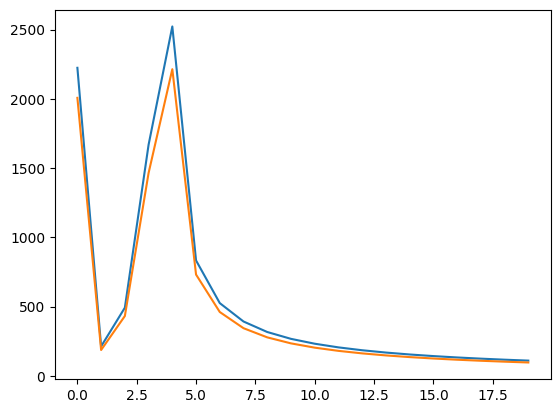

In [122]:
b_fft = np.abs(fft.fft(b_complex_incs_deg.real))
c_fft = np.abs(fft.fft(c_complex_incs_deg.real))
max_freq = np.argmax(b_fft)
print(b_fft[max_freq] / c_fft[max_freq])
print(eigvs[0, 0] / eigvs[1, 0])
plt.plot(b_fft[ :20])
plt.plot(c_fft[ :20])